<a href="https://colab.research.google.com/github/rfps09/Monitoria/blob/main/SemanaAcademica/SemanaAcademicaIris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rede neural para classificação de iris

Carregando e separando os dados, em 80% para treino e 20% para teste, 10% dos 80% vão para validação

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data = np.genfromtxt('drive/MyDrive/TensorFlow/DataSets/iris.data', delimiter=',')
data = np.delete(data,-1,axis=1)
classe = np.genfromtxt('drive/MyDrive/TensorFlow/DataSets/iris.data', delimiter=',', dtype=str,usecols=-1)
classe = np.unique(classe,return_inverse=1)[1]

data_treino, data_teste, classe_treino, classe_teste = train_test_split(data,classe,test_size=0.2, random_state=123, stratify=classe)

classe_treino_onehot = to_categorical(classe_treino)

Criando a rede neural

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_model(numInput,numClasses):
  model = Sequential()
  model.add(Dense(20,activation='tanh', input_dim=numInput))
  model.add(Dense(numClasses,activation='softmax'))
  model.compile('Adam','categorical_crossentropy', metrics=['categorical_accuracy'])

  return model

model = create_model(4,3)

history = model.fit(data_treino,classe_treino_onehot,epochs=500, validation_split=0.1)

Epoch 1/500
4/4 [==============================] - 2s 116ms/step - loss: 1.0245 - categorical_accuracy: 0.5093 - val_loss: 1.0406 - val_categorical_accuracy: 0.5000
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 1.0010 - categorical_accuracy: 0.5278 - val_loss: 1.0237 - val_categorical_accuracy: 0.5000
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.9826 - categorical_accuracy: 0.4722 - val_loss: 1.0098 - val_categorical_accuracy: 0.5000
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.9614 - categorical_accuracy: 0.4444 - val_loss: 0.9904 - val_categorical_accuracy: 0.5000
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 0.9424 - categorical_accuracy: 0.4352 - val_loss: 0.9748 - val_categorical_accuracy: 0.4167
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 0.9242 - categorical_accuracy: 0.4722 - val_loss: 0.9571 - val_categorical_accuracy: 0.5000
Epoch 7/500
4/4 

Modelo da rede neural

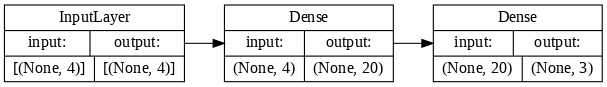

In [55]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True,show_layer_names=False,rankdir="LR",dpi=80)

Gráficos

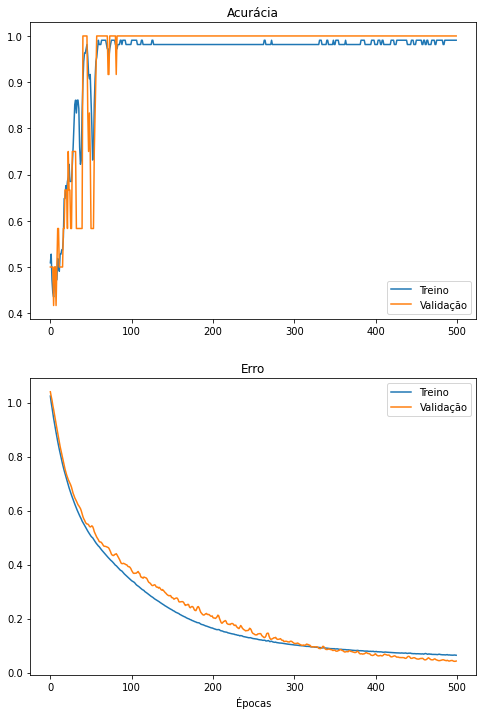

In [56]:
import matplotlib.pyplot as plt

def plot_metrics(history):
  fig, axes = plt.subplots(2,1,figsize=(8,12))

  #  "Accuracy"
  axes[0].plot(history.history['categorical_accuracy'])
  axes[0].set_title('Acurácia')
  # "Loss"
  axes[1].plot(history.history['loss'])
  axes[1].set_title('Erro')

  if 'val_loss' in history.history.keys():
    axes[0].plot(history.history['val_categorical_accuracy'])
    axes[1].plot(history.history['val_loss'])
    axes[0].legend(['Treino', 'Validação'])
    axes[1].legend(['Treino', 'Validação'])

  plt.xlabel('Épocas')

  plt.show()

plot_metrics(history)

Testando a rede neural

In [57]:
classe_predita_onehot = model.predict(data_teste)
classe_predita = classe_predita_onehot.argmax(axis=1)

1/1 [==============================] - 0s 59ms/step


Matriz de confusão

In [58]:
#Matriz de confusão já com 3 classes:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

matriz_confusao = confusion_matrix(classe_teste, classe_predita, labels=range(3))
print(matriz_confusao)

[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


Métricas

In [59]:
#https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

print('Precision or positive predictive: %.3f' % precision_score(classe_teste,classe_predita,average='weighted',zero_division=1))
print('Recall or Sensitivity: %.3f' % recall_score(classe_teste, classe_predita,average='weighted',zero_division=1))
print('Accuracy: %.3f' % accuracy_score(classe_teste, classe_predita))
print('F1 Score: %.3f' % f1_score(classe_teste, classe_predita,average='weighted',zero_division=1))
print('Precision Recall F1-Score Support for each class:')
#print(precision_recall_fscore_support(lista_classes_originais, lista_classes_preditas,average='weighted',labels=[0,1,2,3]))
precision, recall, fscore, support = precision_recall_fscore_support(classe_teste, classe_predita,
    zero_division=1)
print('precision or positive predictive: {}'.format(precision))
print('recall or sensitivity: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

#The diagonal entries are the accuracies of each class
matriz_confusao = matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis]
acuracia_classes = matriz_confusao.diagonal()
print('Accuracy for each class:')
print(acuracia_classes)

print(classification_report(classe_teste, classe_predita, zero_division=1))

Precision or positive predictive: 0.970
Recall or Sensitivity: 0.967
Accuracy: 0.967
F1 Score: 0.967
Precision Recall F1-Score Support for each class:
precision or positive predictive: [1.         1.         0.90909091]
recall or sensitivity: [1.  0.9 1. ]
fscore: [1.         0.94736842 0.95238095]
support: [10 10 10]
Accuracy for each class:
[1.  0.9 1. ]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

